#### Simulación de RNN para predecir Tª en base a imágenes multiespectro

In [42]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Preparación de datos

In [43]:
n_images = 1000 # Número de imágenes
n_bands = 7 # Número de bandas espectrales por imagen
n_rows = 128 # Filas (píxeles)
n_cols = 128 # Columnas (píxeles)

# Simular array con los valores de las imágenes
img_data = np.random.rand(n_images, n_bands, n_rows, n_cols)

# Reducir una dimensión calculando directamente los píxeles
n_pixels = n_rows * n_cols
img_data_reshaped = img_data.reshape(n_images, n_bands, n_pixels)

# Simular temperaturas asociadas y escalarlas
temps = np.random.rand(n_images, 1) * 40 # Genera temperaturas entre 0º y 40º
temp_scaler = MinMaxScaler()
temps_scaled = temp_scaler.fit_transform(temps)

División entre entrenamiento y validación

In [44]:
X_train, X_test, y_train, y_test = train_test_split(img_data_reshaped, temps_scaled, test_size=0.25)

Construcción de la RNN

In [45]:
# Capa de entrada, cada banda espectral es un paso en la secuencia
inputs = layers.Input(shape=(n_bands, n_pixels))

# Capas LSTM con retorno de secuencias para aplicar la Atención después
lstm1 = layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(inputs)
lstm2 = layers.LSTM(128, return_sequences=True)(lstm1)

# Capa de Atención
att = layers.Attention()([lstm2, lstm2])

# Aplanar el output de Atención
context_vector = layers.Flatten()(att)

# Capas densas y salida
dense_1 = layers.Dense(64, activation='relu')(context_vector)
dense_2 = layers.Dense(32, activation='relu')(dense_1)
outputs = layers.Dense(1, activation='linear')(dense_2)

# Construcción y compilación
rnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Entrenamiento

In [46]:
# Crear un early stopper
early_stop = EarlyStopping(
    monitor='val_loss', # Pérdida en validación como referencia
    patience=7, # Detiene el entrenamiento si no hay mejoras tras 7 rondas
    restore_best_weights=True # Recupera los mejores pesos obtenidos
)

In [47]:
history = rnn_model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test),
                        epochs=30,
                        batch_size=32,
                        callbacks=[early_stop]
                        )

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 0.2668 - mae: 0.4057 - val_loss: 0.0832 - val_mae: 0.2505
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 0.0833 - mae: 0.2490 - val_loss: 0.1041 - val_mae: 0.2687
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - loss: 0.0881 - mae: 0.2511 - val_loss: 0.0836 - val_mae: 0.2507
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - loss: 0.0852 - mae: 0.2524 - val_loss: 0.0850 - val_mae: 0.2528
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - loss: 0.0904 - mae: 0.2610 - val_loss: 0.0915 - val_mae: 0.2574
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - loss: 0.0897 - mae: 0.2599 - val_loss: 0.0838 - val_mae: 0.2508
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - loss: 0.0901 - mae: 0.2608 - val_loss: 0.0882 - val_mae: 0.2544
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - loss: 0.0900 - mae: 0.2558 - val_loss: 0.0830 - val_mae: 0.2506
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - lo

Evaluación y gráficos

In [48]:
valid_error = rnn_model.evaluate(X_test, y_test)

# Desescalar los datos para verlos en una relación 0ºC - 40ºC
mse = valid_error[0] * (temp_scaler.data_max_ - temp_scaler.data_min_)**2
mae = valid_error[1] * (temp_scaler.data_max_ - temp_scaler.data_min_)
print(f'Mean Squared Error: {float(mse[0]):.2f} ºC')
print(f'Mean Absolute Error: {float(mae[0]):.2f} ºC')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0861 - mae: 0.2542
Mean Squared Error: 132.61 ºC
Mean Absolute Error: 10.02 ºC


In [53]:
# Reescalar las predicciones y el test para evaluar la gráfica
predicted_temps = rnn_model.predict(X_test)
predicted_temps_reescaled = temp_scaler.inverse_transform(predicted_temps)
y_test_reescaled = temp_scaler.inverse_transform(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


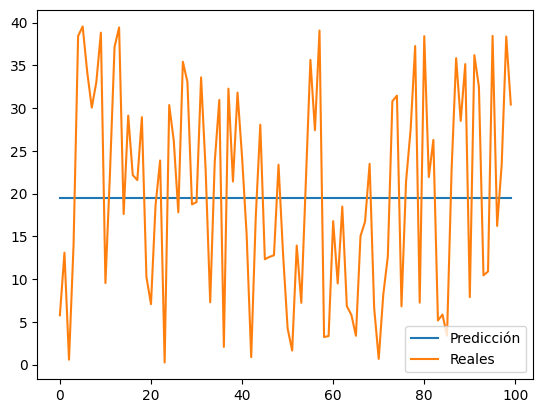

In [56]:
plt.plot(predicted_temps_reescaled[:100], label='Predicción')
plt.plot(y_test_reescaled[:100], label='Reales')
plt.legend()
plt.show()

Dado que es una simulación con datos aleatorios, no hay patrones que el modelo pueda aprender, por lo que devuelve un resultado constante que se sitúa en la media entre los 0ºC y 40ºC